Author: Juan Nicolas Piedrahita Salas

Github: https://github.com/JPHITA

# Load Dependencies

In [55]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import cv2

from google.colab import output
output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

%matplotlib ipympl

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib ipympl 
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.0+cu118
Torchvision version: 0.15.1+cu118
CUDA is available: True
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-gpwoxa2k
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-gpwoxa2k
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 567662b0fd33ca4b022d94d3b8de896628cd32dd
  Preparing metadata (setup.py) ... done
--2023-04-29 23:45:07--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.249.39.6, 13.249.39.25, 13.249.39.89, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.249.39.6|:443... connected.
HTTP request sent, await

# Load SAM model 

In [56]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

# set the image to work with

In [57]:
from google.colab import files
uploaded = files.upload()

image = cv2.imread(list(uploaded.keys())[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

Saving IMG_20190504_191450.jpg to IMG_20190504_191450 (3).jpg


# Select the points to be masked

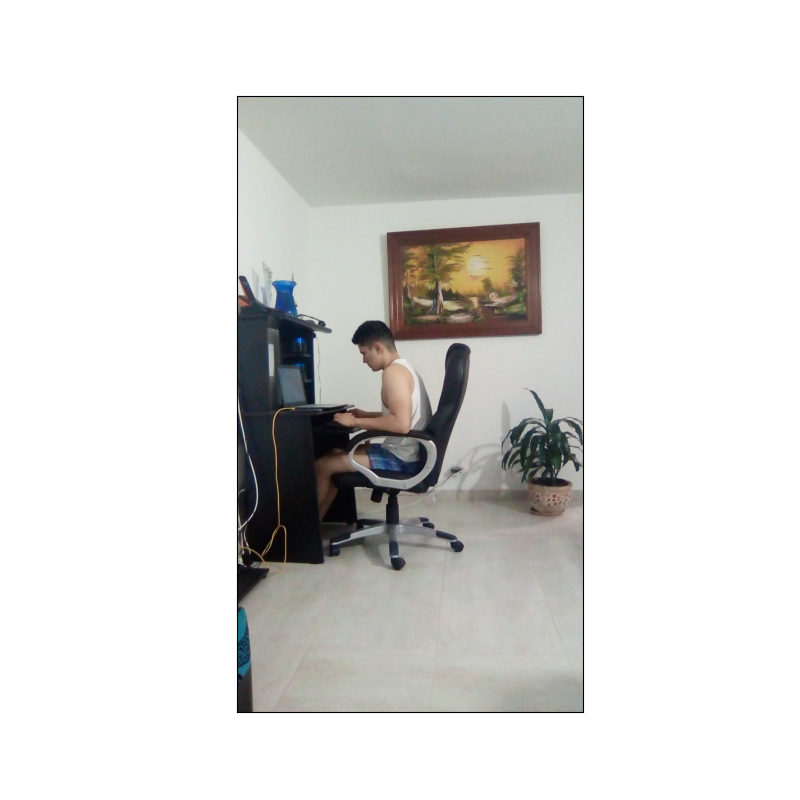

In [125]:
input_points = []
input_labels = []
def on_click(event):
    global ax
    from matplotlib.backend_bases import MouseButton

    if event.button is MouseButton.LEFT:
        input_points.append( [(event.xdata, event.ydata)] )
        input_labels.append([1])

        ax.plot(event.xdata, event.ydata, marker="o", markersize=10)

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(image)
fig.canvas.mpl_connect('button_press_event', on_click)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

# ask for the mask

In [126]:
predictor.set_image(image)

input_points = torch.tensor(input_points, device=predictor.device)
input_labels = torch.tensor(input_labels, device=predictor.device)

transformed_points = predictor.transform.apply_coords_torch(input_points, image.shape[:2])

masks, _, _ = predictor.predict_torch(
    point_coords = transformed_points,
    point_labels = input_labels,
    multimask_output = False
)

# show the results

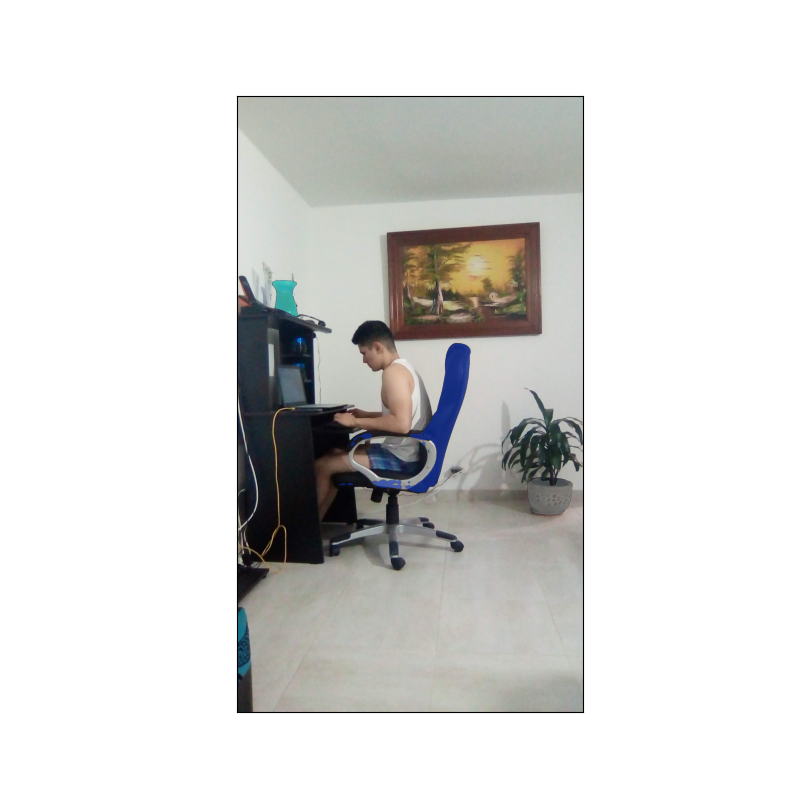

In [127]:
plt.figure(figsize=(8,8))

plt.imshow(image)

for mask in masks:
    mask = mask.cpu().numpy()
    mask = np.expand_dims(mask[0,:,:], 2)

    color = np.random.random((1,1,4))
    color[0,0,-1] = 0.6

    mask = mask * color

    plt.imshow(mask)

plt.xticks([])
plt.yticks([])
plt.show()

# show a crop for each mask

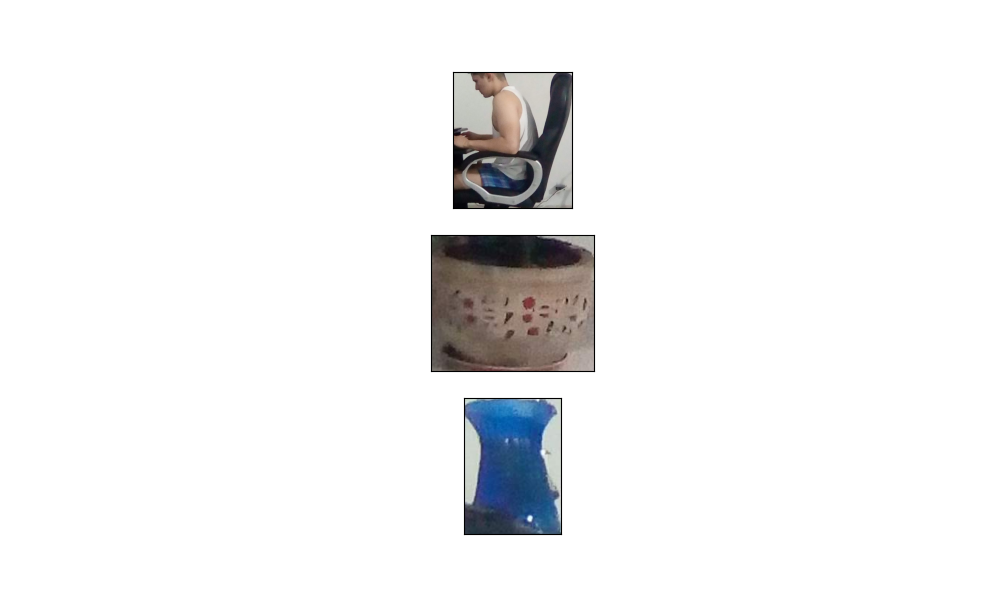

In [145]:
_, axes = plt.subplots(masks.shape[0], 1, figsize=(10,6))
for i, mask in enumerate(masks):
    
    (minV, maxV), (minH, maxH) = map(lambda ar: (ar.min(), ar.max()), np.nonzero(mask.cpu().numpy()[0]))

    axes[i].imshow(image[minV:maxV, minH:maxH, :])
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.show()